In [1]:
import numpy as np
import astropy
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
import pymc
from scipy.optimize import curve_fit
import subprocess

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
class FIRC_galaxy:
    '''
    a class containing teh observed properties of a radio galaxy from
    which other properties can be calculated/derived
    '''
    def __init__(self,z,flux_rad,totlir,vobs,spec_index):
        '''
        initialise the galaxy with a redshift, flux a an observed 
        frequecy and a spectral index
        flux should be given in jy
        '''
        self.z = z
        self.flux_rad = flux_rad * 1E-26
        self.totlir = totlir
        self.vobs = vobs
        self.spec_index = spec_index
        
    def radio_kcorrection(self,vrest):
        '''
        k corrects a radio luminosity from the original frequency to a new
        frequency assuming a given spectral index using the formula
    
        lnew = lold * (fnew/fold)^-spec_index
    
        Parameters
        ----------------------------
        vobs - frequency of the given raduio luminosity
        vrest - frequecny of the k corrceted luminsoity
        spec_index - assumed spectral index
        fobs - flux at the frequnecy vold
    
        Returns
        -------------------------------
        frest - flux at the frequnecy vnew
        '''
    
        frest = self.flux_rad * (vrest/self.vobs)**(self.spec_index)
        return(frest)
    
    def radio_luminosity(self,vrest):
        flux = self.radio_kcorrection(vrest)
        distance = cosmo.luminosity_distance(self.z).to(u.m).value
        lum = flux * 4 * np.pi * distance*distance
        return(lum)
    
    def rad2fir(self,q):
        '''
        Given a q value and a radio luminosity at 1.4GHz in W/Hz 
        returns the total FIR luminosity from 8-1000um in solar
        luminsoities
        '''
    
        fir = q + np.log10(3.75E12 * self.radio_luminosity(1.4))
        return(10**fir/(3.827E26))
    
    def plot_firc(self,vrest):
        x = np.log10(self.radio_luminosity(vrest))
        y = np.log10(self.totlir)
        plt.scatter(x,y,s=0.1)
        return(x,y)
        
    def plot_q_z(self,vrest):
        x = self.z
        q = np.log10(self.totlir/(3.75E12)) - np.log10(self.radio_luminosity(vrest))
        y = q
        plt.scatter(x,y,s=0.1)
        return(x,y)
        
    

In [4]:
def agn_selection(table,c1=0.08,c2=0.15,c3=1.21,c4=0.27):
    '''
    returns a masked column for the sources with True corresponding to AGN selected bby the Donley et al 2012
    selection criteria.
    NOTE: this function can be used to see the affects or changing the criteria slightly
    '''
    i1 = table['f_irac_i1']
    i2 = table['f_irac_i2']
    i3 = table['f_irac_i3']
    i4 = table['f_irac_i4']
    x = np.log10(i3/i1)
    y = np.log10(i4/i2)
    
    crit1 = (x>=c1) & (y>=c2) & (y>=(c3*x-c4)) & (y<=(c3*x+c4))
    crit2 = (i2>i1) & (i3>i2) & (i4>i3)
    mask = crit1 & crit2
    
    plt.scatter(x,y,s=1.0,c='blue')
    plt.scatter(x[mask],y[mask],s=1.0,c='red')
    
    return(mask)

In [5]:
def linear_fit(x,c):
    y = x+c
    return(y)

In [6]:
def double_exp_fit(x,sig1,var1,A1,sig2,var2,A2):
    exp1 = A1/(np.sqrt(2*np.pi)*var1) * np.exp(-(x-sig1)**2/(2*var1**2))
    exp2 = A2/(np.sqrt(2*np.pi)*var2) * np.exp(-(x-sig2)**2/(2*var2**2))
    return(exp1+exp2)

In [7]:
xmatch_data = Table.read('../../../HELP/dmu_products/dmu12/data/xmatch_all_masterlist_20181026.fits')

In [8]:
mask = xmatch_data['lr_sel_4'] & (~np.isnan(xmatch_data['cigale_dustlumin']))
firc_data = xmatch_data[mask]

In [9]:
firc_data[0]

Source_id,Isl_id,RA_1,E_RA,DEC_1,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,lr_i,lr_dist_i,lr_index_i,lr_reliability_i,helpid_i,lr_index_sel_i,lr_w1,lr_dist_w1,lr_index_w1,lr_reliability_w1,helpid_w1,lr_index_sel_w1,lr_index_1,lr_dist_1,lr_1,lr_type_1,category,m_irac_i1_1,m_megacam_r_1,lr_index_2,lr_dist_2,lr_2,lr_reliability_2,helpid_2,lr_index_sel_2,lr_index_3,lr_dist_3,lr_3,lr_reliability_3,help_id_1,lr_sel_3,lr_index_4,lr_dist_4,lr_4,lr_reliability_4,help_id_2,lr_sel_4,help_id,field,ra_2,dec_2,hp_idx,f_ap_wfc_u,ferr_ap_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,f_wfc_u,ferr_wfc_u,m_wfc_u,merr_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,f_wfc_g,ferr_wfc_g,m_wfc_g,merr_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,f_wfc_r,ferr_wfc_r,m_wfc_r,merr_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,f_wfc_i,ferr_wfc_i,m_wfc_i,merr_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,f_wfc_z,ferr_wfc_z,m_wfc_z,merr_wfc_z,f_ap_gpc1_g,ferr_ap_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,m_gpc1_g,merr_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,m_gpc1_r,merr_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,m_gpc1_i,merr_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,m_gpc1_z,merr_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_r,ferr_megacam_r,m_megacam_r_2,merr_megacam_r,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,m_ukidss_k,merr_ukidss_k,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1_2,merr_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,m_ukidss_j,merr_ukidss_j,m_megacam_i,ferr_megacam_i,merr_megacam_i,flag_megacam_i,f_megacam_i,m_megacam_y,ferr_megacam_y,merr_megacam_y,flag_megacam_y,f_megacam_y,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec,zspec_qual,zspec_association_flag,ebv,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,redshift,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly
,,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,Jy / beam,Jy / beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,deg,deg,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [10]:
galaxies = FIRC_galaxy(firc_data['redshift'],firc_data['Total_flux'],firc_data['cigale_dustlumin'],0.15,-0.8)

/its/home/im281/anaconda3/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


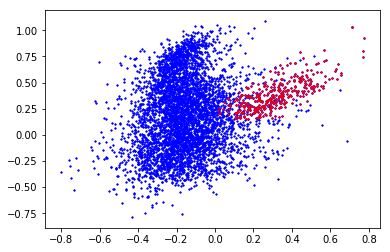

q = 14.975890306587695


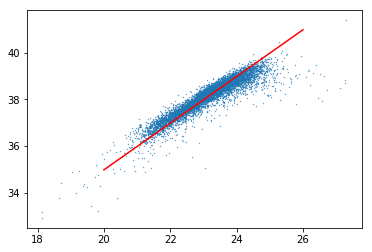

In [11]:
mask = ~agn_selection(firc_data,c1=0.0)
agnsel = agn_selection(firc_data,c1=0.0)
agngalaxies = FIRC_galaxy(firc_data['redshift'][agnsel],firc_data['Total_flux'][agnsel],firc_data['cigale_dustlumin'][agnsel],0.15,-0.7)
sfgalaxies = FIRC_galaxy(firc_data['redshift'][mask],firc_data['Total_flux'][mask],firc_data['cigale_dustlumin'][mask],0.15,-0.7)
plt.show()
x,y = sfgalaxies.plot_firc(1.4)
#agngalaxies.plot_firc(1.4)
c,_ = curve_fit(linear_fit,x,y,p0=[2.7])
c,_ = curve_fit(linear_fit,x,y,p0=[2.7])
print('q = {}'.format(c[0]))
x = np.linspace(20,26,10)
y = linear_fit(x,c)
plt.plot(x,y,color='red')
plt.show()



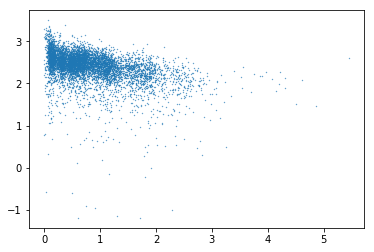

/its/home/im281/anaconda3/envs/herschelhelp/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


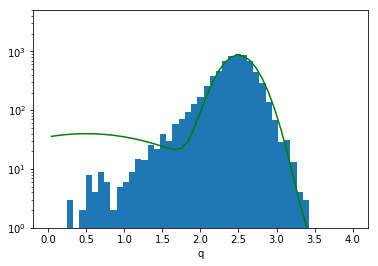

In [12]:
_,q = sfgalaxies.plot_q_z(1.4)
plt.show()
qbin,_ = np.histogram(q,bins=np.linspace(0,4,50))
params,_ = curve_fit(double_exp_fit,get_center(np.linspace(0,4,50)),qbin,p0=[2.5,1,1000,0.5,2,10])
sig1,var1,A1,sig2,var2,A2 = params

plt.hist(q,bins=np.linspace(0,4,50),log=True)
x = get_center(np.linspace(0,4,50))
y = double_exp_fit(x,sig1,var1,A1,sig2,var2,A2)
#plt.plot(x,y,color='red')

x = x = get_center(np.linspace(0,4,50))
y = double_exp_fit(x,2.5,0.23,500,0.5,1,100)
plt.plot(x,y,color='green')
plt.ylim(1,5000)
plt.xlabel('q')
plt.show()

In [13]:
cands = firc_data['help_id']

In [20]:
print(cands[0])
print(len(cands[0].replace(' ','')))
print(len('HELP_J110317.771+574040.887'))
url = 'http://hedam.lam.fr/HELP/dataproducts/dmu28/dmu28_Lockman-SWIRE/data/zphot/best_extcor/SEDs/fits/HELP_J110317.771+574040.887_best_model.fits'
#subprocess.call(['curl','-O',url])

HELP_J110317.771+574040.887      
27
27


In [26]:
for m,cand in enumerate(cands):
    if m%100==0:
        print(m)
    n = cand.replace(' ','')
    url = 'http://hedam.lam.fr/HELP/dataproducts/dmu28/dmu28_Lockman-SWIRE/data/zphot/best_extcor/SEDs/fits/{}_best_model.fits'.format(n)
    subprocess.call(['curl','-O',url])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


In [63]:
n = 6
z = firc_data['redshift'][n]
test = Table.read('{}_best_model.fits'.format(firc_data['help_id'][n].replace(' ','')))

In [68]:
agnfirratio = []
for n in range(len(firc_data)):
    z = firc_data['redshift'][n]
    test = Table.read('{}_best_model.fits'.format(firc_data['help_id'][n].replace(' ','')))

    mask = (test['wavelength']>8000) & (test['wavelength']<1E6)
    x = np.log10(test['wavelength'][mask])
    y = np.log10(test['Fnu'][mask])
    #plt.plot(x,y)
    #distance = cosmo.luminosity_distance(z).to(u.m).value
    agnlum = np.sum(test['agn.fritz2006_therm'][mask] + test['agn.fritz2006_scatt'][mask])

    #plt.show()
    agnfirratio.append(agnlum/firc_data['cigale_dustlumin'][n])
    print(agnlum/firc_data['cigale_dustlumin'][n])

0.0003088596828236264
0.0
0.0008739065410737962
0.0
0.00042678420257566467
0.0
0.0
0.0
0.0005501398783303604
0.0
0.0004039999209482056
0.0002276514676916073
0.0
0.0
0.0004967919403195483
0.0006586165215350277
0.0
0.000252789417658854
0.0
0.0
0.0011692749852578255
0.00039424452163615536
0.0
0.0
0.0
0.0
0.0005518660927949668
0.0
0.0
0.0
0.0
0.000356053162833413
0.0
0.00038609526644823526
0.0
0.0
0.00037647394785585527
0.0
0.0
0.0004187549062001504
0.0
0.0
0.0
0.0
0.0007245151587586578
0.0007451732420537878
0.0004664943054346777
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00042251609425087653
0.0005251035607850117
0.0036979045969693504
0.0
0.0004341398381119473
0.0
0.0013185890626933904
0.0
0.0004640245582959036
0.0
0.0008518335258976248
0.0006118598981048876
0.0003251151148962469
0.0006095855910502132
0.0
0.0
0.0
0.0
0.0
0.0003400566171411634
0.0011414105901005735
0.0
0.00036906014149523534
0.0
0.0005731046726447515
0.0009715295613249442
0.0
0.0
0.0003212352237504987
0.00035957914153955206
0.00033

0.0
0.0
0.000499898767012653
0.0
0.0010492918789090204
0.0
0.0
0.0
0.00043898232494898073
0.0
0.0
0.0
0.003646022820725046
0.023822987776061694
0.004460068554095001
0.0
0.0
0.0
0.0009708918697938915
0.0012853193596887179
0.0006816670101314294
0.0006906434215644063
0.0003489198062818308
0.0
0.0006733721105847588
0.0
0.000740254606033627
0.0
0.0
0.0
0.0
0.00039699554561414537
0.0
0.0008843303951984246
0.0
0.0004500470585463441
0.0005246007018583322
0.0
0.0
0.0007266810291100206
0.0011384995349016545
0.0009014535359882677
0.0
0.0004476476054370305
0.0
0.019274212835312186
0.0009052685171515885
0.0
0.0
0.0004914632037685363
0.0
0.0
0.0
0.0
0.0
0.0004863131321829616
0.0009015136119782279
0.0
0.00048562770454324577
0.0
0.0
0.003937955381121821
0.0
0.0
0.0
0.0
0.00114855783876957
0.0
0.00039631509694831423
0.0007472908210132229
0.0
0.0010537209411068146
0.0005076884837767481
0.0
0.0011673827260268023
0.0
0.004361780370186793
0.0
0.0005533771971874346
0.0
0.0
0.0
0.0
0.0005040450376462199
0.00

0.0
0.0
0.0016353000854345053
0.0
0.00039205279826950106
0.0
0.0008230865343847851
0.00047104011329004086
0.0
0.0
0.0007107603096804196
0.0
0.0
0.0002941867090444903
0.0006558064469809452
0.0007009734537170084
0.0
0.0
0.0003856902381519264
0.000336350750886943
0.0018344879473695865
0.0006516988173221183
0.0009107358948336779
0.0003677145995039328
0.0
0.0010570040295473364
0.0
0.0007863279782671209
0.0
0.0005717208381100213
0.0
0.0008895956573257264
0.0009132844834342776
0.004668737997763987
0.0
0.0
0.0
0.0007776913393306256
0.0
0.004767180585128906
0.0003380295366714795
0.0
0.0
0.000766419326597727
0.00035552136332903626
0.0011726140111701063
0.00040060587670984947
0.0002778970186399824
0.00043760648652880395
0.00043415446875897816
0.0
0.0
0.0003952242251249506
0.0003455588376740249
0.000708601021110745
0.0
0.0005545252599444266
0.0
0.0
0.0008463539678740241
0.0
0.0
0.0
0.0007978945839525514
0.0
0.0016746125608689312
0.0008446360661399116
0.0
0.0
0.0006084046550063575
0.0
0.00235056192

0.0
0.002052259360881262
0.0
0.0
0.0004518920508576309
0.0009287999518246371
0.0
0.0
0.02633845837672362
0.0007205291491084889
0.0
0.0
0.0
0.00047597013973761215
0.0011997542153861782
0.0
0.0
0.0007745500602943651
0.0004298614250378793
0.0
0.0
0.03444258548637514
0.0
0.0014542837930732494
0.0007019861052110017
0.0
0.0010193410909462093
0.0006750737066991422
0.001291435000482567
0.0
0.0
0.0
0.0007299808172780358
0.0
0.0
0.00043754887685586006
0.0
0.0
0.00037440951265302363
0.0
0.0
0.0
0.00036973107348071033
0.0
0.0
0.00037165477653790344
0.0
0.0
0.0
0.00038050475910945855
0.0
0.0
0.0003291237049324343
0.0
0.0
0.0
0.0
0.0
0.0
0.0006904499238674979
0.0
0.0
0.0
0.0
0.0
0.0
0.0003175486689945879
0.0
0.0
0.0007501346222900796
0.0003375048339751885
0.0
0.0
0.00042561935249141807
0.0
0.0007519729736872167
0.0
0.00040293211804734257
0.023467903677839182
0.0
0.00031557552820340345
0.0
0.0005987502816357552
0.001619977395835387
0.0003639799374585749
0.0009463046648280841
0.0
0.0
0.000717594079945

0.0
0.0
0.00029152920309770766
0.0
0.0
0.0007820507759328593
0.0
0.0014041275491441202
0.0010068775383832108
0.0
0.0
0.0
0.00040479234885225146
0.0
0.0006802824246338104
0.0007122054113528045
0.0
0.0004570342535336899
0.009033606539942616
0.00047949222032977795
0.0
0.03826404368326145
0.0008016840402314785
0.002058051358171437
0.0
0.0
0.0
0.0005709320547221231
0.000371396694514075
0.0004775748477566742
0.0
0.0
0.0
0.0
0.00040992035733736264
0.0
0.0
0.0
0.0
0.0
0.0
0.0007992898941084841
0.0
0.0004945891532893141
0.0
0.0
0.0
0.0008825206118077039
0.00045883265262244334
0.0003716649247280259
0.0018568142466810589
0.0
0.0
0.0005386433273373762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0017946798065564017
0.0
0.0
0.0005998131895084165
0.000575533705778209
0.0006978508173544187
0.0011737754290040518
0.0
0.0
0.0
0.0
0.0
0.0
0.0015717604012745832
0.0
0.0
0.0
0.0
0.0
0.00023289008269291523
0.0
0.0004040099501816615
0.0
0.0009497153236746801
0.0
0.0003753407232959331
0.0
0.0007427188054056837
0.0
0.

0.0010609593299975844
0.0
0.0
0.0
0.0
0.00044466668121893383
0.00026300509132055156
0.0
0.0
0.0
0.000832143752371904
0.0
0.0
0.0
0.0004570936141104799
0.004320964085427708
0.0004504170681142879
0.0003867046543586441
0.0003268292492875031
0.0004077763466422191
0.0
0.0031865422385068086
0.0014061805890035468
0.0
0.0
0.0004144488840653339
0.0
0.0
0.0
0.0012872123734033293
0.00030698303381753784
0.00045067561812737404
0.0
0.0006989352454217482
0.0
0.0
0.0016434429075006813
0.0
0.0
0.0
0.0
0.0
0.0004714619403732825
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00462020655679366
0.0
0.0005926091822481002
0.00044946968374565653
0.0
0.000914873479496646
0.0
0.0007597477524342257
0.0007981330757710375
0.0
0.0007788541177548048
0.0
0.0
0.0
0.0007862726370163444
0.0
0.0004391505335704809
0.0
0.0005476584373024603
0.0
0.0
0.0
0.0
0.00027517727856486354
0.0
0.0003047718054091271
0.00037873085305982046
0.0
0.0
0.0006788459701402234
0.0
0.004623786134711866
0.0
0.0
0.00051172265472750

0.0006776396325859467
0.0
0.0012104573538546423
0.0
0.0014604877019680637
0.0003518192969954102
0.0005017120547753168
0.0
0.0
0.0
0.0
0.0
0.0
0.000727212945552799
0.0
0.0
0.0
0.0
0.0023765727852854183
0.0
0.0008950037778243023
0.0
0.0
0.00020181559015560073
0.0
0.00044075700453807224
0.0006515649401416756
0.000713890629817076
0.0007813277283586079
0.0
0.0
0.0013924711042780527
0.0
0.0003949067705313852
0.0
0.0
0.0
0.0
0.0012708575020063885
0.0
0.0006147193391588665
0.0
0.000990867408245217
0.0
0.0
0.00039026775550422496
0.0
0.0
0.0
0.0008012989289464655
0.0
0.0038419860009802505
0.0
0.0008124647335548756
0.0
0.0
0.0004888571323537206
0.00048331825212111446
0.0
0.0
0.0
0.0
0.0
0.0008979121585163552
0.0006636070199273921
0.0004221045215854596
0.0004124682409366876
0.0
0.00036928399421699756
0.0003854678321173273
0.0005363249257793369
0.0005171684906985097
0.0
0.0003149257403471239
0.0
0.000341221948433345
0.0
0.0006643683947782567
0.0
0.0024217390930032154
0.00045015791260201985
0.000616

0.0
0.0
0.0
0.0
0.0
0.0004916868947497414
0.0
0.0
0.022083425210562026
0.0
0.0
0.0
0.0
0.0015403196560791214
0.0
0.0002975089567810567
0.0
0.000782489126831748
0.0
0.0
0.0002747466235623411
0.0
0.0007322714626529983
0.0003326984097535294
0.00032615240740601714
0.0
0.0013572952408600414
0.0
0.004389594404671272
0.0
0.0
0.0
0.0
0.0
0.0007021245189827042
0.0
0.014443841461530485
0.0
0.0005040197641204096
0.0003579517577578536
0.00045062395674760766
0.0
0.0004006390344602776
0.0
0.0005355006400570274
0.0013888586514925988
0.00032967024571817753
0.0007522200617643148
0.0
0.00047012370593496557
0.0
0.0
0.0
0.0
0.006044177292217765
0.0008939288548275725
0.00034513584146002524
0.0005945504405493306
0.0014126349135955556
0.0
0.0008146907508741389
0.0
0.0033648046059980233
0.0
0.001677164134645359
0.0002746677649401287
0.0005279933916850425
0.0
0.0
0.0
0.0003998918172680447
0.0
0.0
0.0005721362363586913
0.0003713762567537124
0.0
0.0
0.0
0.00020449049868906028
0.0
0.0
0.0
0.0
0.0
0.00023260819784

0.0
0.0
0.0005012275887267302
0.0008081721340084429
0.0
0.0
0.0002214904841009717
0.0
0.00044514001412068434
0.0004499818960990213
0.0011663607558585999
0.0005679861616599663
0.0
0.0
0.0
0.0
0.0
0.0
0.0008519727602951082
0.0
0.0
0.0004087112033593224
0.0
0.0
0.0015011806660717665
0.0005640497647815435
0.0
0.0
0.0
0.0014949046345556622
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005241835528959472
0.0004111507359363927
0.004774724082402298
0.0
0.0
0.0
0.0007515667327542051
0.0
0.0
0.0014435944166308005
0.0015212742822230069
0.0005946888399805337
0.0006829567122723784
0.0004646139936976676
0.0006521310069044121
0.00036923091184235614
0.0
0.0
0.0
0.0
0.000460923381605139
0.0014486542504532497
0.0005896537961221079
0.0016393884320197029
0.0
0.0006697464000395378
0.0
0.0
0.0
0.0
0.0
0.0004521020650911362
0.0
0.0004187885362228303
0.00023588958571291388
0.0
0.00034066773754808544
0.0
0.0
0.0
0.0
0.00036739999587461587
0.0006939458629759261
0.00043802449396566
0.00020785149870211086
0.00081731

0.0007766698327363418
0.0
0.0
0.0005339274869374056
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005326460165687944
0.0006409623096846792
0.0008975801485187503
0.0
0.0
0.000308576367359279
0.0
0.0004946143877867159
0.00036616565914949367
0.0
0.0
0.0
0.0
0.0020567960571474544
0.0
0.0036478377354423625
0.0006198876595737493
0.0
0.0
0.0009459485282127857
0.0
0.0
0.0032459067865664155
0.0
0.0009821611249730049
0.0
0.00022056970282316842
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0012644623177462478
0.0
0.00033177937915705453
0.0004902463436411797
0.0
0.0004937687106278558
0.0004717057993053635
0.0
0.0020769611887336502
0.0
0.0
0.0
0.0
0.00026481572045139305
0.0
0.0
0.0033702726616270055
0.0
0.0
0.0
0.0
0.001321333680934157
0.0004931939377871662
0.0
0.0
0.0007079058709514542
0.0011738405700848522
0.001845157070871604
0.0007232565127007428
0.0
0.0002538195052344527
0.0
0.0
0.0
0.0
0.0
0.0007007955370957463
0.0
0.003968874984820648
0.00032370139534314935
0.0
0.000444765618288321
0.0
0.0
0.0
0.0
0.0
0.0
0.00

0.0
0.0
0.0
0.001606208355242287
0.0003229287958087366
0.0
0.024436111594272347
0.0
0.0003273336278370893
0.0
0.0
0.0
0.0
0.0
0.0004873344021791696
0.0
0.0
0.0
0.0
0.0
0.0
0.00041434463778054683
0.0
0.0
0.0
0.0
0.00048341048476450494
0.0004980093060801472
0.0005037132687604084
0.0
0.0
0.0005624479023416031
0.0
0.0037417671985248992
0.0
0.0017753521120888207
0.0007473390668004825
0.0010252803178735553
0.0
0.0
0.0
0.0007213716213854582
0.0
0.0007864342629878135
0.0
0.0
0.0
0.0006788308996464832
0.0029386543039769163
0.0
0.0
0.0
0.0003882201215574326
0.0
0.00037682997306924326
0.0
0.0
0.0
0.0
0.0
0.0030994099643601005
0.0
0.0
0.0
0.00042676269535590737
0.0
0.0014164288122747097
0.0004064044519028595
0.000386109113656243
0.0004989013765239412
0.0
0.0
0.0
0.0011106367036179644
0.0
0.00033429267283651283
0.00018478156143716807
0.0003603861660495953
0.0
0.0008042291926592773
0.0
0.0
0.00043136459118192985
0.0004392403333943104
0.0
0.0
0.0
0.0
0.0008669491248629632
0.0
0.0
0.000273278060611455

In [67]:
np.max(agnfirratio)

0.056305562341136935